<a href="https://colab.research.google.com/github/bitanb1999/RF-and-Boosting/blob/main/RF_and_Boosting_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practicalities of Random Forests and Gradient Boosted Regression Trees

We will look here into the practicalities of fitting random forests and GBRT. These involve out-of-bound estmates and cross-validation, and how you might want to deal with hyperparameters in these models. Along the way we will play a little bit with different loss functions, so that you start thinking about what goes in general into cooking up a machine learning model.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.datasets import fetch_california_housing

## Dataset

First, the data. This one is built into sklearn, its a dataset about california housing prices. Its quite skewed as we shall see.

In [2]:
cal_housing = sklearn.datasets.fetch_california_housing()

In [3]:
print(cal_housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# split 80/20 train-test
Xtrain, Xtest, ytrain, ytest = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.3)
names = cal_housing.feature_names

In [6]:
ytrain.shape, ytest.shape

((14448,), (6192,))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


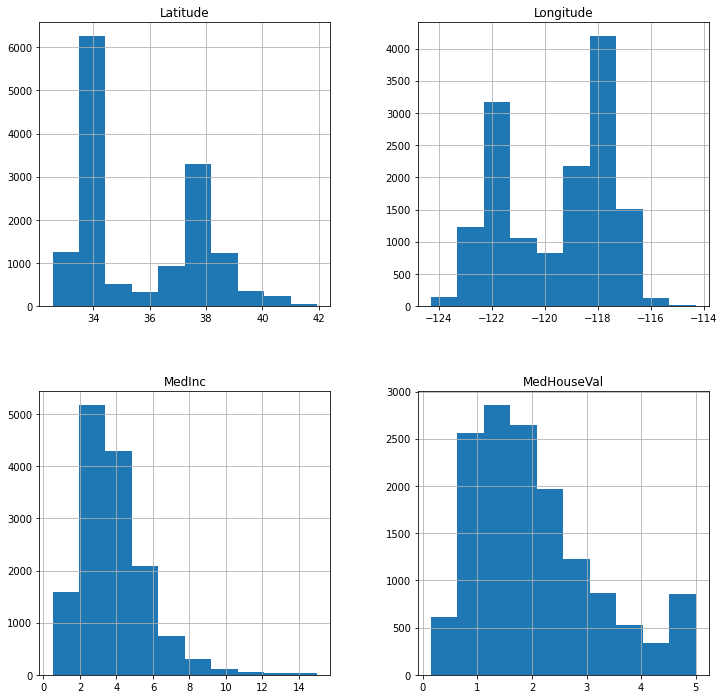

In [7]:
df = pd.DataFrame(data=Xtrain, columns=names)
df['MedHouseVal'] = ytrain
fig, ax = plt.subplots(figsize=(12,12))
df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal'], ax=ax);

Notice the high bump in the median house value. why do you think that is? How might you model it?

In [8]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,6.9833,10.0,10.765466,1.853186,2186.0,2.018467,33.69,-116.39,2.388
1,2.8043,16.0,5.158228,0.989451,721.0,1.521097,37.99,-122.06,0.875
2,4.0588,45.0,5.822275,1.054502,1129.0,2.675355,37.68,-122.13,1.828
3,2.7717,25.0,5.791757,1.143167,936.0,2.030369,33.12,-117.32,3.540
4,1.6111,26.0,3.656134,1.072491,692.0,1.286245,33.76,-118.08,0.543


In [9]:
df.shape

(14448, 9)

## General Trees

We could use a simple Decision Tree regressor to fit such a model. 

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

## Random Forests

Whats the basic idea?

- Decision trees overfit
- So lets introduce randomization.
- Randomization 1: Use bootstrap resampling to create different training datasets. This way each training will give us a different tree and the robust aspects of the regression will remain.
- Added advantage is that the left off points can be used to "validate"
- Just like in polynomials we can choose a large `max_depth` and we are ok as we expect the robust signal to remain

### Bagging Hyper-parameters and Tuning Strategy

- recall we want somewhat overfit trees at the very least. But start by having unrestricted trees. We dont want bias in our trees.
- now we will want to increase the number of trees in our ensemble (start about 20-30). Since each tree only sees about 2/3 of the data, increasing the number of trees `n_estimators` increases the use of our training data.
- there will be a number of trees at which this error asymptotes. Adding more trees is not useful. This is because the ensemble has now seen ALL the training data. We are approaching the accuracy of a single tree without its variance.


- for some datasets, using fully grown trees (no limits on samples in leaf or max depth) may not work as the degree of randomization bagging can achieve is not enough to overcome the variance (overfitting). This is partly because of correlation
-  Depending on the dataset you will want to choose `max_depth` and `min_samples_leaf` so that you are overfit but not highly overfit. (the most bang for the buck comes from adjusting `min_samples_leaf` upwards, but you might need to play with `max_depth` as well)
- subsampling without replacement might be an option because it will decorrelate trees. If you use $$B/2$$ subsamples you get similar results to bagging. (See [here](http://statweb.stanford.edu/~jhf/ftp/bag.pdf).) But our trees now have more bias.
- you can do grid search or informal play as long as your compare performance on OOB or the validation set.



### Random Forest Hyperparameters and Tuning Strategy

- Not much tuning needed. As for bagging, we want to start with unrestricted trees.
- Start with 20-30 trees and add more trees until validation error stops getting better.
- Max features needs to be tuned. Try $$\sqrt{p}$$, or even lower $$log(p)$$ but do not make it too low.
- You may still be overfit with unrestricted trees, so then adjust `min_samples_leaf` upwards.
- you can do grid search or informal play as long as your compare performance on OOB or the validation set.


#### Building in even more variance

- you could make the random forest choose from a restricted feature list to make things even more randomized.
- `sklearn` has `ExtraTreesClassifier` and `ExtraTreesRegressor` classes, which take the careful impurity minimization from decision trees and throw it out... See [Geurts et al](https://link.springer.com/article/10.1007/s10994-006-6226-1).
- That paper (and sklearn) pick a random split AND a random set of features. The fit is done without bootstrapping or subsampling to increase accuracy now that we are not trying to minimize impurity
- sklearn propagates random splits, bootstrap/no-bootstrap and `max_features` down even to decision trees class so you can play with these choices in the context of Bagging, or even Boosting.

---

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[400, 600, 800], [0.2, 0.4, 0.6, 0.8]])

Here we create a Param Grid. We are preparing to use the bootstrap points not used to validate.

```
max_features : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you might as well leave those at defaults to get a maximally expanded tree.

### Using the OOB score.

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [12]:
from itertools import product

In [13]:
results = {}
estimators= {}
for n, f in product(*param_dict.values()):
    params = (n, f)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=n, max_features=f, n_jobs=-1)
    est.fit(Xtrain, ytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(600, 0.4)

In [14]:
rf1 = estimators[outparams]

In [15]:
results

{(400, 0.2): 0.7874943522367958,
 (400, 0.4): 0.8164441033161274,
 (400, 0.6): 0.8136486449398679,
 (400, 0.8): 0.8061068751750526,
 (600, 0.2): 0.7877933781432064,
 (600, 0.4): 0.8172588580531532,
 (600, 0.6): 0.8134819982896413,
 (600, 0.8): 0.8069589356189376,
 (800, 0.2): 0.7883077781570141,
 (800, 0.4): 0.8171192423293651,
 (800, 0.6): 0.8136715489522891,
 (800, 0.8): 0.8071557879669072}

In [16]:
rf1.score(Xtest, ytest)

0.8266450087732605

Since our response is very skewed at the higher end, we may want to suppress outliers by using the `mean_absolute_error` instead. We could also use a ladder transformation.

In [17]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, rf1.predict(Xtest))

0.32028863977857897

`sklearn` supports this (`criterion='mae'`) since 0.18, but does not have arbitrary loss functions for Random Forests. You can try fitting with MAE as the decision tree loss.


Finally you can get feature importances. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion such as gini. This is accumulated over all trees and reported in `est.feature_importances_`

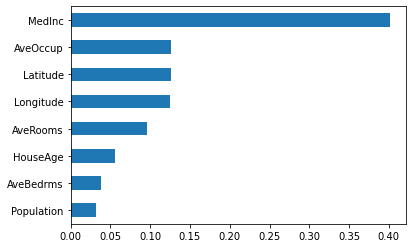

In [18]:
pd.Series(rf1.feature_importances_, index=names).sort_values().plot(kind="barh")

### Seeing error as a function of the number of trees

We can instead, of different `max_features` see how performance varies across the number of trees one uses: (this will take a while to run!)

In [19]:
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 200
num_steps = 3
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(Xtrain, ytrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

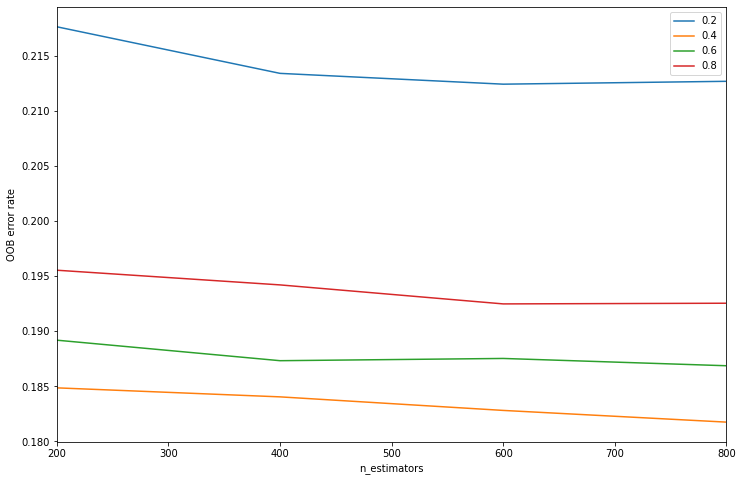

In [20]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
fig, ax = plt.subplots(figsize=(12, 8))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    ax.plot(xs, ys, label=label)

ax.set_xlim(min_estimators, max_estimators)
ax.set_xlabel("n_estimators")
ax.set_ylabel("OOB error rate")
ax.legend(loc="upper right")

The OOB error decreases with the number of trees, but goes up at the best `max_features`. 600 trees is probably about right.

## Gradient Boosted Regression Trees

Adaboost Classification is a special case of a gradient-boosted algorithm. 

But briefly, let us cover the idea here. The idea is that we will use a bunch of weak learners and fit sequentially. The first one fits the signal, the second one the first residual, the third the second residual and so on. At each stage we up-weight the places that our previous learner did badly on. 

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. Increasing it increases the variance usually as you fit more complex trees.

We can think of decomposing a boosted tree regression function using an ANOVA expansion:

$$
f(\mathbf{x})=\sum_{j} f_{j}\left(x_{j}\right)+\sum_{j k} f_{j k}\left(x_{j}, x_{k}\right)+\sum_{j k \ell} f_{j k \ell}\left(x_{j}, x_{k}, x_{\ell}\right)+\cdots
$$


- Regression stumps (one split decision trees) depend on only one variable (first term),-  - - Two splits fall into the second term, finds 2 way interactions and so on and so-forth. 

The depth of the trees controls the order of approximation. Often additive components are sufficient. Then we can also produce partial dependence plots of $x_{j}$ versus $f_{j}\left(x_{j}\right)$ to demonstrate how changes in $x_{j}$ might affect changes in the response variable.

### Ok, so how to do the fit?

In [22]:
gb = GradientBoostingRegressor(n_estimators=1000, max_depth=5)
gb.fit(Xtrain, ytrain)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

A deviance plot can be used to compare train and test errors against the number of iterations.

- Training error (deviance, another word for loss) is stored in `est.train_score_`
- Test error is computed using `est.staged_predict` (this uses `est.loss_`)

In [23]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig, ax = plt.subplots(figsize = (12, 8))
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

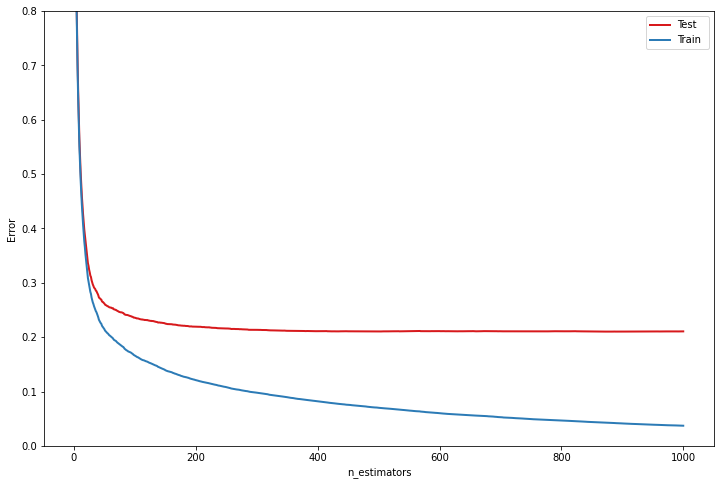

In [24]:
deviance_plot(gb, Xtest, ytest, ylim=(0,0.8));
plt.legend();

Notice the wide gap. This is an indication of overfitting!

Unlike random forests, where we are using the randomness to our benefits, the GBRT requires careful cross-validation

## Tuning a Gradient Boosted Model or Adaboost

This formula is from Peter Preffenhorfer who wrote `sklearn`'s GBRT implementation. In his pydata14 talk (worth watching!) he says

1. Pick `n_estimators` as large as (computationally) possible (e.g. 3000)
2. Tune `max_depth`, `learning_rate`, `min_samples_leaf`, and `max_features` via grid search
3. A lower `learning_rate` (shrinkage) requires a higher number of `n_estimators`. Thus increase `n_estimators` even more and tune learning_rate again holding the other parameters fixed

This last point is a tradeoff between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

I will add however, that poor learners do rather well. So you might want to not cross-validate `max_depth`. And `min_samples_per_leaf` is not independent either, so if you do use cross-val, you might just use one of those.

### Cross Validation with Huber Loss

The Huber Loss may be used to deal with outliers. Here is a diagram from Cornell's CS4780:

![](http://www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/pngPic/c4/regressionlosses.png)

We'll create a rough param grid to figure where the hyperparameters lie. You can engage in finer grid search later.

In [25]:
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [3, 6],
              'min_samples_leaf': [3, 5],  ## depends on the num of training examples
              'max_features': [0.2, 0.6]
              }

In [26]:
from sklearn.model_selection import GridSearchCV
gb = GradientBoostingRegressor(n_estimators=600, loss='huber')
gb_cv = GridSearchCV(gb, param_grid, cv=3, n_jobs=-1)

This will take some time! We've made a smaller grid, but things are still slow

In [27]:
gb_cv.fit(Xtrain, ytrain)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=600,
                                                 n_iter_no_change=None,
              

In [28]:
gb_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=6, max_features=0.6, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

We get a slightly better MAE than Random Forest, even though the model scoring was done on mean squared error. 

There is a price to be paid, however, time costly cross-validation. At the cost of less data in the training model, Gradient boosted trees can use subsampling and thus report a OOB score. See the `subsample` option in [`GradientBoostedRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

Notice that the criterion on the splits uses a specific MSE, and we did not score on cross-validation by another loss, simply using MSE.

In [29]:
mean_absolute_error(ytest, gb_cv.predict(Xtest))

0.2888102389897343

And the deviance plot shows a huge narrowing of the gap!

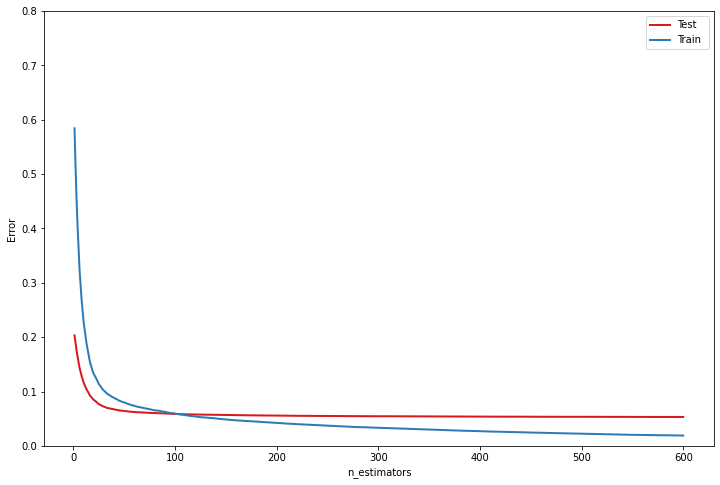

In [30]:
deviance_plot(gb_cv.best_estimator_, Xtest, ytest, ylim=(0,0.8));
plt.legend();

We are still overfit above 100 trees. We could **early stop** at about 100 trees or play a bit more with our parameter hyperspace. We could make a smaller independent test set (validation set) and uses subsampling with OOB instead to reduce the amount of time it takes to train. (R's [`gbm`](https://cran.r-project.org/web/packages/gbm/vignettes/gbm.pdf) module, also great place to learn about Gradient boosting Models does this by default._

In [31]:
bp = gb_cv.best_params_
bp

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 0.6,
 'min_samples_leaf': 3}

Even though the predictions are not bad, I would not trust the parameters on such a small grid, as in practice these hyper-parameters tend to be highly correlated.

We can now play with the number of iterations and the learning rate.

In [32]:
param_grid2 = {'learning_rate': [0.1, 0.01, 0.001]}

In [33]:
gb2 = GradientBoostingRegressor(n_estimators=1000, 
                                loss="huber", 
                                max_depth=bp['max_depth'],
                                max_features=bp['max_features'],
                                min_samples_leaf=bp['min_samples_leaf'])

In [34]:
gb2_cv = GridSearchCV(gb2, param_grid2, cv=3, n_jobs=-1)

In [35]:
gb2_cv.fit(Xtrain, ytrain)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=6,
                                                 max_features=0.6,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=3,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000,
                                                 n_iter_no_change=None,
              

In [36]:
gb2_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=6, max_features=0.6, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [37]:
mean_absolute_error(ytest, gb2_cv.predict(Xtest))

0.2882865315085999

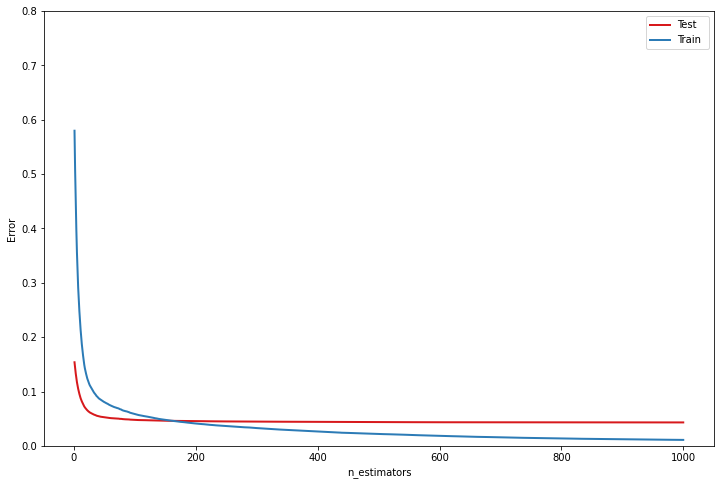

In [38]:
deviance_plot(gb2_cv.best_estimator_, Xtest, ytest, ylim=(0,0.8));
plt.legend();

We are slightly better. Feature importances again:

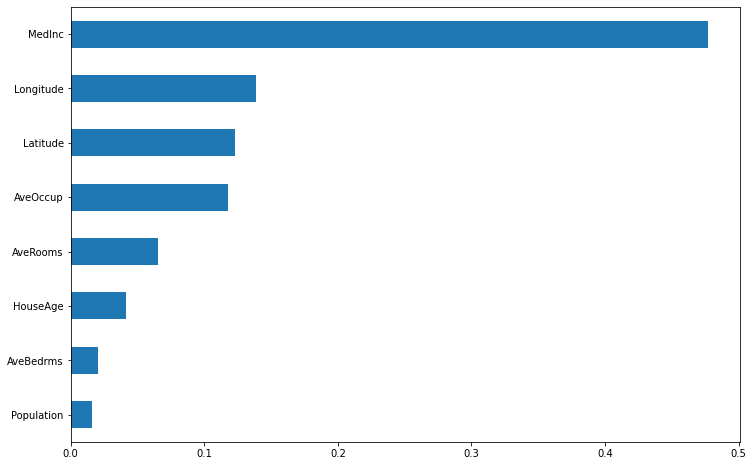

In [39]:
plt.figure(figsize=(12, 8))
pd.Series(gb2_cv.best_estimator_.feature_importances_, index=names).sort_values().plot(kind="barh");

### Tips:

- ordinal encoding in trees for categorical variables is as effective as one-hot encoding but more efficient, using less memory and being faster. But your trees need to be deeper as you are making more cuts
- often explicit interactions  are useful in GBRT so some `max_depth` is not bad.

Try to repeat the process using the Huber loss and the MAE for scoring